# Embeddings

⚠️ **Uwaga!**

W celu wykonania tych ćwiczeń wymagane jest skonfigurowanie deploymentu modelu `text-embedding-3-small` w Azure AI Foundry.

📹 [Instrukcja konfiguracji (YouTube)](https://youtu.be/wjZofJX0v4M?t=747&si=Ae3F1WiGbqypo5yP)

# 🚀 Text Embeddings — Interactive Educational Journey

Welcome to your hands-on exploration of text embeddings! This notebook takes you
through the fundamental concepts of how words become vectors, using practical
examples that you can run, modify, and experiment with.

**🎯 What You'll Learn:**
- What embeddings are and how they work (dimensions, magnitude, statistics)
- Similarity metrics and their interpretation (cosine, euclidean, dot product)
- Counterintuitive patterns in language relationships (the cat-dog mystery)
- How context affects meaning in vector space
- Semantic clustering and 2D visualization with PCA and t-SNE
- Similarity heatmaps for comprehensive relationship matrices
- The famous king-queen analogy and vector arithmetic

**🔧 Prerequisites:**
- Azure OpenAI credentials in `.env` file (see `.env.example`)
- Python 3.13+ with `openai`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dotenv import load_dotenv
from openai.lib.azure import AzureOpenAI
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv(override=True)

azure_openai_client = AzureOpenAI()
embedding_cache: dict[str, list[float]] = {}

In [ ]:
@dataclass(frozen=True)
class WordPair:
    first: str
    second: str


@dataclass(frozen=True)
class AnalogyTestCase:
    source_word: str
    subtract_word: str
    add_word: str
    expected_target: str


def fetch_embedding(
        text: str,
        *,
        client: AzureOpenAI,
        cache: dict[str, list[float]],
        model_name: str = "text-embedding-3-small",
) -> list[float]:
    """Generates an embedding vector for the given text using Azure OpenAI's API, with caching."""
    if text in cache:
        return cache[text]

    cleaned_text = text.replace("\n", " ")
    embedding_response = client.embeddings.create(input=[cleaned_text], model=model_name)
    embedding_vector = embedding_response.data[0].embedding
    cache[text] = embedding_vector
    print(f"Generated embedding for: '{text}' (dimension: {len(embedding_vector)})")
    return embedding_vector


def fetch_embeddings_batch(
        texts: list[str],
        *,
        client: AzureOpenAI,
        cache: dict[str, list[float]],
        model_name: str = "text-embedding-3-small",
) -> list[list[float]]:
    """Generates embeddings for multiple texts in a single API call, with caching."""
    uncached_texts = [text for text in texts if text not in cache]

    if uncached_texts:
        cleaned_texts = [text.replace("\n", " ") for text in uncached_texts]
        response = client.embeddings.create(input=cleaned_texts, model=model_name)

        for i, uncached_text in enumerate(uncached_texts):
            cache[uncached_text] = response.data[i].embedding

    return [cache[text] for text in texts]


def compute_cosine_similarity(vector_a: list[float], vector_b: list[float]) -> float:
    """Calculates cosine similarity between two embedding vectors."""
    return cosine_similarity([vector_a], [vector_b])[0][0]


def compute_euclidean_distance(vector_a: list[float], vector_b: list[float]) -> float:
    """Calculates Euclidean distance between two embedding vectors."""
    return float(np.linalg.norm(np.array(vector_a) - np.array(vector_b)))


def compare_two_words(
        word_a: str,
        word_b: str,
        *,
        client: AzureOpenAI,
        cache: dict[str, list[float]],
) -> dict[str, float]:
    """Compares two words using cosine similarity, euclidean distance, and dot product."""
    embedding_a = fetch_embedding(word_a, client=client, cache=cache)
    embedding_b = fetch_embedding(word_b, client=client, cache=cache)

    return {
        "cosine_similarity": float(compute_cosine_similarity(embedding_a, embedding_b)),
        "euclidean_distance": float(compute_euclidean_distance(embedding_a, embedding_b)),
        "dot_product": float(np.dot(embedding_a, embedding_b)),
    }


def compute_analogy_similarity(
        analogy: AnalogyTestCase,
        *,
        word_vectors: dict[str, np.ndarray],
        client: AzureOpenAI,
        cache: dict[str, list[float]],
) -> float:
    """Computes vector arithmetic for an analogy and returns cosine similarity to the expected target."""
    for word in [analogy.source_word, analogy.subtract_word, analogy.add_word, analogy.expected_target]:
        if word not in word_vectors:
            word_vectors[word] = np.array(fetch_embedding(word, client=client, cache=cache))

    analogy_result_vector = (
            word_vectors[analogy.source_word]
            - word_vectors[analogy.subtract_word]
            + word_vectors[analogy.add_word]
    )
    return compute_cosine_similarity(
        analogy_result_vector.tolist(), word_vectors[analogy.expected_target].tolist()
    )


def plot_2d_word_clusters(
        reduced_embeddings: np.ndarray,
        *,
        all_words: list[str],
        word_to_group_name: dict[str, str],
        semantic_groups: dict[str, list[str]],
        title: str,
        x_label: str,
        y_label: str,
) -> None:
    """Plots a 2D scatter chart of word embeddings colored by semantic group."""
    plt.figure(figsize=(12, 8))
    group_colors = ["red", "blue", "green", "orange"]

    for group_name, color in zip(semantic_groups.keys(), group_colors):
        group_word_indices = [
            idx for idx, word in enumerate(all_words)
            if word_to_group_name[word] == group_name
        ]
        group_x_coords = reduced_embeddings[group_word_indices, 0]
        group_y_coords = reduced_embeddings[group_word_indices, 1]

        plt.scatter(group_x_coords, group_y_coords, c=color, label=group_name, alpha=0.7, s=100)

        for word_idx in group_word_indices:
            plt.annotate(
                all_words[word_idx],
                (reduced_embeddings[word_idx, 0], reduced_embeddings[word_idx, 1]),
                fontsize=10,
                alpha=0.8,
            )

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def print_cluster_analysis(
        embeddings: list | np.ndarray,
        *,
        all_words: list[str],
        word_to_group_name: dict[str, str],
) -> None:
    """Computes and prints intra-cluster vs inter-cluster similarity statistics."""
    intra_cluster_similarities: list[float] = []
    inter_cluster_similarities: list[float] = []

    for i in range(len(all_words)):
        for j in range(i + 1, len(all_words)):
            pairwise_similarity = compute_cosine_similarity(
                list(embeddings[i]), list(embeddings[j])
            )

            if word_to_group_name[all_words[i]] == word_to_group_name[all_words[j]]:
                intra_cluster_similarities.append(pairwise_similarity)
            else:
                inter_cluster_similarities.append(pairwise_similarity)

    average_intra = np.mean(intra_cluster_similarities)
    average_inter = np.mean(inter_cluster_similarities)

    print(f"\nCluster Analysis:")
    print(f"Average intra-cluster similarity: {average_intra:.4f}")
    print(f"Average inter-cluster similarity: {average_inter:.4f}")
    print(f"Clustering effectiveness: {average_intra - average_inter:.4f}")

### 1. Basic Embeddings 📊

Embeddings are high-dimensional numerical vectors that capture semantic meaning.

**Key properties:**
- Each word/phrase maps to a fixed-size vector (e.g., 1536 dimensions for `text-embedding-3-small`)
- OpenAI normalizes embeddings to unit length (~1.0 magnitude)
- Each dimension captures different semantic features
- The statistics (min, max, mean, std) reveal the distribution of values

In [ ]:
print("=" * 60)
print("DEMO 1: BASIC EMBEDDINGS")
print("=" * 60)

sample_word = "cat"
embedding_vector = fetch_embedding(sample_word, client=azure_openai_client, cache=embedding_cache)
embedding_array = np.array(embedding_vector)

print(f"Word: '{sample_word}'")
print(f"Embedding dimensions: {len(embedding_vector)}")
print(f"First 5 dimensions: {embedding_vector[:5]}")
print(f"Embedding magnitude: {np.linalg.norm(embedding_array):.4f}")

print(f"\nEmbedding statistics:")
print(f"Min value: {min(embedding_vector):.6f}")
print(f"Max value: {max(embedding_vector):.6f}")
print(f"Mean: {np.mean(embedding_array):.6f}")
print(f"Standard deviation: {np.std(embedding_array):.6f}")

### 2. Word Similarity Analysis 🔗

Similarity metrics measure how semantically related two words are.

**Three metrics compared:**
- **Cosine Similarity** — measures angle between vectors (higher = more similar)
- **Euclidean Distance** — measures straight-line distance (lower = more similar)
- **Dot Product** — magnitude-weighted similarity (correlates with similarity)

In [ ]:
print("=" * 60)
print("DEMO 2: WORD SIMILARITY ANALYSIS")
print("=" * 60)

word_pairs_to_compare: list[WordPair] = [
    WordPair(first="cat", second="dog"),
    WordPair(first="cat", second="kitten"),
    WordPair(first="dog", second="puppy"),
    WordPair(first="king", second="queen"),
    WordPair(first="man", second="woman"),
    WordPair(first="happy", second="joyful"),
    WordPair(first="car", second="automobile"),
    WordPair(first="bratwurst", second="sushi"),
]

print(f"{'Word Pair':<20} {'Cosine Sim':>12} {'Euclidean':>12} {'Dot Product':>12}")
print("-" * 58)

for pair in word_pairs_to_compare:
    metrics = compare_two_words(pair.first, pair.second, client=azure_openai_client, cache=embedding_cache)
    print(
        f"{pair.first}-{pair.second:<15} {metrics['cosine_similarity']:>12.4f} "
        f"{metrics['euclidean_distance']:>12.4f} {metrics['dot_product']:>12.4f}"
    )

print("\nKey Observations:")
print("• Higher cosine similarity = more semantically similar")
print("• Lower euclidean distance = more similar")
print("• Dot product magnitude correlates with similarity")

### 3. The Cat-Dog Mystery 🤔

**The Counterintuitive Finding:** Why is `cat` more similar to `dog` than to `kitten`?

Embeddings capture statistical patterns of word usage, **NOT** biological taxonomy:
- Co-occurrence in similar contexts matters most
- `cat` and `dog` appear in nearly identical sentence structures
- Semantic level relationships (both adult animals, pets) dominate
- `kitten` occupies a slightly different contextual niche (youth, cuteness)

In [ ]:
print("=" * 60)
print("DEMO 3: THE CAT-DOG MYSTERY")
print("=" * 60)

cat_dog_metrics = compare_two_words("cat", "dog", client=azure_openai_client, cache=embedding_cache)
cat_kitten_metrics = compare_two_words("cat", "kitten", client=azure_openai_client, cache=embedding_cache)

print("The Counterintuitive Finding:")
print(f"cat-dog similarity:    {cat_dog_metrics['cosine_similarity']:.4f}")
print(f"cat-kitten similarity: {cat_kitten_metrics['cosine_similarity']:.4f}")
print(f"Difference: {cat_dog_metrics['cosine_similarity'] - cat_kitten_metrics['cosine_similarity']:.4f}")

if cat_dog_metrics["cosine_similarity"] > cat_kitten_metrics["cosine_similarity"]:
    print("\n🤔 Why is 'cat' more similar to 'dog' than to 'kitten'?")
    print("\nThis demonstrates that embeddings capture:")
    print("• Statistical patterns of word usage")
    print("• Co-occurrence in similar contexts")
    print("• Semantic level relationships (adult animals)")
    print("• NOT biological or taxonomic relationships")

### 4. Context Matters 🎭

Context dramatically changes how words relate to each other in vector space.

**Key insight:** The same word pair can have reversed similarity rankings
depending on the surrounding context. Phrases capture richer meaning
than individual words, and context can completely flip relationships.

In [ ]:
print("=" * 60)
print("DEMO 4: CONTEXT MATTERS")
print("=" * 60)

context_templates = [
    "The {} is sleeping peacefully",
    "I love my {} very much",
    "A {} playing with a toy",
    "Training a {} requires patience",
]

context_test_words = ["cat", "dog", "kitten"]

print("Similarity changes with context:")
print(f"{'Context':<35} {'cat-dog':>10} {'cat-kitten':>12} {'Difference':>12}")
print("-" * 70)

for template in context_templates:
    phrases = [template.format(word) for word in context_test_words]
    phrase_embeddings = fetch_embeddings_batch(phrases, client=azure_openai_client, cache=embedding_cache)

    cat_phrase_embedding, dog_phrase_embedding, kitten_phrase_embedding = phrase_embeddings

    cat_dog_similarity = compute_cosine_similarity(cat_phrase_embedding, dog_phrase_embedding)
    cat_kitten_similarity = compute_cosine_similarity(cat_phrase_embedding, kitten_phrase_embedding)
    similarity_difference = cat_dog_similarity - cat_kitten_similarity

    truncated_context = template.replace(" {} ", " [X] ")[:30] + "..."
    print(
        f"{truncated_context:<35} {cat_dog_similarity:>10.4f} "
        f"{cat_kitten_similarity:>12.4f} {similarity_difference:>12.4f}"
    )

print("\nKey Insight: Context can reverse similarity relationships!")

### 5. Semantic Clustering 🗂️

Related concepts naturally cluster together in embedding space.

Using **PCA** (Principal Component Analysis) and **t-SNE** we project high-dimensional
embeddings into 2D for visualization. Words from the same category
should appear close together, demonstrating that embeddings organize
knowledge into meaningful semantic neighborhoods.

In [6]:
print("=" * 60)
print("DEMO 5: SEMANTIC CLUSTERS VISUALIZATION")
print("=" * 60)

semantic_groups: dict[str, list[str]] = {
    "Animals": ["cat", "dog", "kitten", "puppy", "bird", "fish"],
    "Food": ["apple", "pizza", "sushi", "bread", "chocolate", "salad"],
    "Transport": ["car", "bicycle", "airplane", "train", "boat", "bus"],
    "Emotions": ["happy", "sad", "angry", "excited", "calm", "surprised"],
}

all_cluster_words: list[str] = []
word_to_group_name: dict[str, str] = {}

for group_name, words_in_group in semantic_groups.items():
    all_cluster_words.extend(words_in_group)
    for word in words_in_group:
        word_to_group_name[word] = group_name

cluster_embeddings = fetch_embeddings_batch(all_cluster_words, client=azure_openai_client, cache=embedding_cache)
embeddings_matrix = np.array(cluster_embeddings)


DEMO 5: SEMANTIC CLUSTERS VISUALIZATION


In [ ]:
pca_reducer = PCA(n_components=2)
pca_reduced_embeddings = pca_reducer.fit_transform(embeddings_matrix)

plot_2d_word_clusters(
    pca_reduced_embeddings,
    all_words=all_cluster_words,
    word_to_group_name=word_to_group_name,
    semantic_groups=semantic_groups,
    title="Word Embeddings Projected to 2D Space (PCA)",
    x_label=f"First Principal Component (explains {pca_reducer.explained_variance_ratio_[0]:.1%} variance)",
    y_label=f"Second Principal Component (explains {pca_reducer.explained_variance_ratio_[1]:.1%} variance)",
)

In [ ]:
print(f"📊 PCA explains {sum(pca_reducer.explained_variance_ratio_):.1%} of total variance")

print_cluster_analysis(
    cluster_embeddings,
    all_words=all_cluster_words,
    word_to_group_name=word_to_group_name,
)

#### 5b. t-SNE Visualization

t-SNE (t-distributed Stochastic Neighbor Embedding) is an alternative dimensionality
reduction technique that often produces tighter visual clusters than PCA,
at the cost of not preserving global distances.

In [25]:
tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=1000)
tsne_reduced_embeddings = tsne_reducer.fit_transform(embeddings_matrix)

plot_2d_word_clusters(
    tsne_reduced_embeddings,
    all_words=all_cluster_words,
    word_to_group_name=word_to_group_name,
    semantic_groups=semantic_groups,
    title="Word Embeddings Projected to 2D Space (t-SNE)",
    x_label="t-SNE Dimension 1",
    y_label="t-SNE Dimension 2",
)


Cluster Analysis:
Average intra-cluster similarity: 0.9321
Average inter-cluster similarity: -0.2405
Clustering effectiveness: 1.1726


In [ ]:
print_cluster_analysis(
    tsne_reduced_embeddings,
    all_words=all_cluster_words,
    word_to_group_name=word_to_group_name,
)

### 6. Similarity Heatmaps 🔥

A similarity heatmap reveals the full relationship matrix between words.

By computing cosine similarity for every word pair, we can visualize
which words are closest and farthest in embedding space. This helps
identify unexpected relationships and validate semantic intuitions.


DEMO 6: SIMILARITY HEATMAP


[]

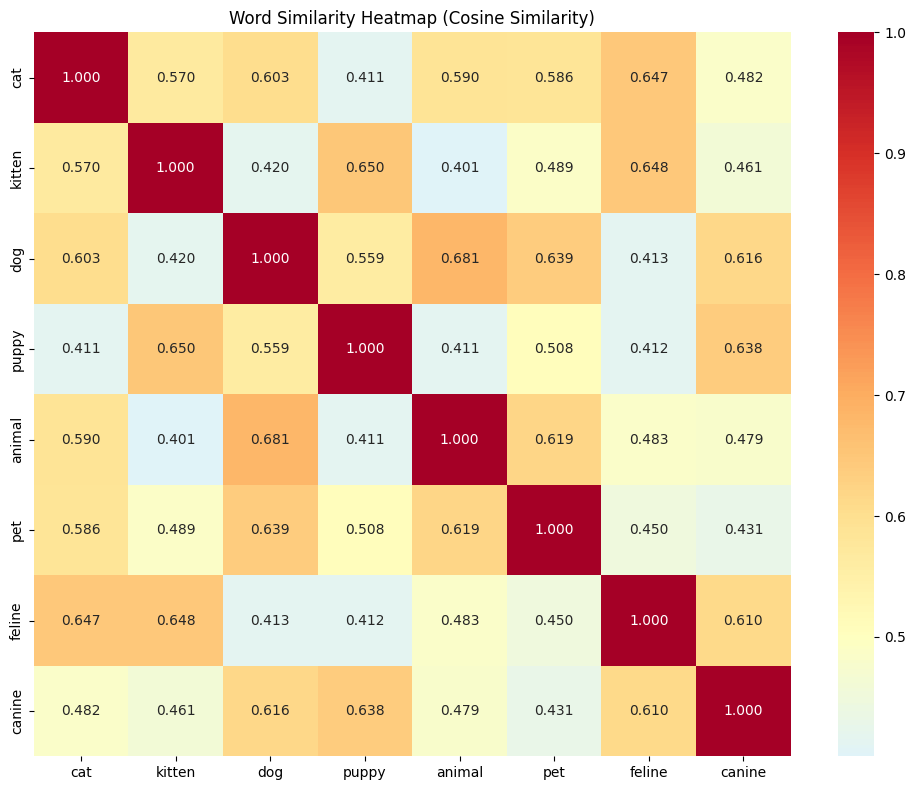

In [10]:
print("=" * 60)
print("DEMO 6: SIMILARITY HEATMAP")
print("=" * 60)

heatmap_words = ["cat", "kitten", "dog", "puppy", "animal", "pet", "feline", "canine"]
heatmap_embeddings = fetch_embeddings_batch(heatmap_words, client=azure_openai_client, cache=embedding_cache)

word_count = len(heatmap_words)
similarity_matrix = np.zeros((word_count, word_count))

for row_idx in range(word_count):
    for col_idx in range(word_count):
        similarity_matrix[row_idx, col_idx] = compute_cosine_similarity(
            heatmap_embeddings[row_idx], heatmap_embeddings[col_idx]
        )

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,
    xticklabels=heatmap_words,
    yticklabels=heatmap_words,
    cmap="RdYlBu_r",
    center=0.5,
    fmt=".3f",
)

plt.title("Word Similarity Heatmap (Cosine Similarity)")
plt.tight_layout()
plt.show()

In [ ]:
np.fill_diagonal(similarity_matrix, -1)
most_similar_indices = np.unravel_index(np.argmax(similarity_matrix), similarity_matrix.shape)

np.fill_diagonal(similarity_matrix, 1)
least_similar_indices = np.unravel_index(np.argmin(similarity_matrix), similarity_matrix.shape)

print(
    f"\nMost similar pair: {heatmap_words[most_similar_indices[0]]}-"
    f"{heatmap_words[most_similar_indices[1]]} "
    f"(similarity: {similarity_matrix[most_similar_indices]:.4f})"
)
print(
    f"Least similar pair: {heatmap_words[least_similar_indices[0]]}-"
    f"{heatmap_words[least_similar_indices[1]]} "
    f"(similarity: {similarity_matrix[least_similar_indices]:.4f})"
)

### 7. Vector Arithmetic Magic 🧮

Vector arithmetic reveals how embeddings encode semantic relationships geometrically.

**The famous analogy:** `king - man + woman ≈ queen`
- `king` - `man` isolates the concept of royalty without gender
- Adding `woman` reintroduces gender in the female direction
- The result lands near `queen` — royalty + female

This works because relationships like gender, royalty, and family roles
emerge as consistent directional offsets in embedding space.

In [12]:
print("=" * 60)
print("DEMO 7: VECTOR ARITHMETIC - THE FAMOUS KING-QUEEN ANALOGY")
print("=" * 60)

print("🎯 Exploring the famous: king - man + woman ≈ queen")
print("This demonstrates how embeddings capture semantic relationships!\n")

print("1. Getting embeddings for the core analogy words...")
core_analogy_words = ["king", "man", "woman", "queen"]
word_vectors: dict[str, np.ndarray] = {}

for word in core_analogy_words:
    word_vectors[word] = np.array(fetch_embedding(word, client=azure_openai_client, cache=embedding_cache))


DEMO 7: VECTOR ARITHMETIC - THE FAMOUS KING-QUEEN ANALOGY
🎯 Exploring the famous: king - man + woman ≈ queen
This demonstrates how embeddings capture semantic relationships!

1. Getting embeddings for the core analogy words...
Using cached embedding for: 'king'
Using cached embedding for: 'man'
Using cached embedding for: 'woman'
Using cached embedding for: 'queen'


In [13]:
print("\n2. Performing vector arithmetic: king - man + woman")
king_minus_man_plus_woman = word_vectors["king"] - word_vectors["man"] + word_vectors["woman"]
print(f"✓ Calculated result vector (dimension: {len(king_minus_man_plus_woman)})")

print("\n3. Comparing result to target word 'queen'...")
queen_similarity_score = compute_cosine_similarity(
    king_minus_man_plus_woman.tolist(), word_vectors["queen"].tolist()
)
print(f"Direct similarity to 'queen': {queen_similarity_score:.4f}")


2. Performing vector arithmetic: king - man + woman
✓ Calculated result vector (dimension: 1536)

3. Comparing result to target word 'queen'...
Direct similarity to 'queen': 0.6162


In [14]:
print("\n4. Testing against candidate words...")
candidate_words = ["queen", "princess", "lady", "woman", "king", "prince", "monarch", "ruler", "empress"]
candidate_similarities: list[tuple[str, float]] = []

for candidate in candidate_words:
    if candidate not in word_vectors:
        word_vectors[candidate] = np.array(fetch_embedding(candidate, client=azure_openai_client, cache=embedding_cache))

    candidate_score = compute_cosine_similarity(
        king_minus_man_plus_woman.tolist(), word_vectors[candidate].tolist()
    )
    candidate_similarities.append((candidate, candidate_score))

candidate_similarities.sort(key=lambda pair: pair[1], reverse=True)

print(f"\n{'Word':<12} {'Similarity':>12} {'Status'}")
print("-" * 35)

queen_rank: int | None = None
for rank_index, (candidate_word, similarity_score) in enumerate(candidate_similarities):
    if candidate_word == "queen":
        status = "🎯 TARGET WORD"
        queen_rank = rank_index + 1
    else:
        status = ""
    print(f"{candidate_word:<12} {similarity_score:>12.4f} {status}")

print(f"\nResult: 'queen' ranked #{queen_rank} out of {len(candidate_similarities)} candidates")

if queen_rank == 1:
    print("✅ PERFECT: The analogy works flawlessly!")
    print("   king - man + woman ≈ queen")
elif queen_rank is not None and queen_rank <= 3:
    print("✅ EXCELLENT: The analogy works very well (top 3 result)")
else:
    print("✅ GOOD: The analogy demonstrates the pattern")

print(f"\n5. Understanding why this works...")
print("The vector arithmetic captures relationships:")
print("• 'king' - 'man' = concept of royalty without gender")
print("• Adding 'woman' = royalty + female gender")
print("• Result ≈ 'queen' = royal female")


4. Testing against candidate words...
Generated embedding for: 'princess' (dimension: 1536)
Generated embedding for: 'lady' (dimension: 1536)
Generated embedding for: 'prince' (dimension: 1536)
Generated embedding for: 'monarch' (dimension: 1536)
Generated embedding for: 'ruler' (dimension: 1536)
Generated embedding for: 'empress' (dimension: 1536)

Word           Similarity Status
-----------------------------------
king               0.7637 
queen              0.6162 🎯 TARGET WORD
woman              0.6022 
princess           0.4647 
lady               0.4468 
ruler              0.4336 
empress            0.4266 
monarch            0.4002 
prince             0.3906 

Result: 'queen' ranked #2 out of 9 candidates
✅ EXCELLENT: The analogy works very well (top 3 result)

5. Understanding why this works...
The vector arithmetic captures relationships:
• 'king' - 'man' = concept of royalty without gender
• Adding 'woman' = royalty + female gender
• Result ≈ 'queen' = royal female


In [16]:
print(f"\n6. Testing other gender-role analogies...")
gender_role_analogies: list[AnalogyTestCase] = [
    AnalogyTestCase(source_word="father", subtract_word="man", add_word="woman", expected_target="mother"),
    AnalogyTestCase(source_word="uncle", subtract_word="man", add_word="woman", expected_target="aunt"),
    AnalogyTestCase(source_word="boy", subtract_word="male", add_word="female", expected_target="girl"),
    AnalogyTestCase(source_word="prince", subtract_word="man", add_word="woman", expected_target="princess"),
]

print(f"\n{'Analogy':<25} {'Target':<8} {'Similarity':>12} {'Success':>10}")
print("-" * 57)

for analogy in gender_role_analogies:
    analogy_similarity = compute_analogy_similarity(
        analogy, word_vectors=word_vectors, client=azure_openai_client, cache=embedding_cache,
    )

    success_indicator = "✅" if analogy_similarity > 0.6 else "⚠️" if analogy_similarity > 0.4 else "❌"
    analogy_description = f"{analogy.source_word} - {analogy.subtract_word} + {analogy.add_word}"
    print(
        f"{analogy_description:<25} {analogy.expected_target:<8} "
        f"{analogy_similarity:>12.4f} {success_indicator:>10}"
    )


6. Testing other gender-role analogies...

Analogy                   Target     Similarity    Success
---------------------------------------------------------
father - man + woman      mother         0.7472          ✅
uncle - man + woman       aunt           0.6910          ✅
boy - male + female       girl           0.7488          ✅
prince - man + woman      princess       0.6849          ✅


In [18]:
print(f"\n7. Testing conceptual analogies...")
conceptual_analogies: list[AnalogyTestCase] = [
    AnalogyTestCase(source_word="Paris", subtract_word="France", add_word="Italy", expected_target="Rome"),
    AnalogyTestCase(source_word="big", subtract_word="bigger", add_word="small", expected_target="smaller"),
    AnalogyTestCase(source_word="walk", subtract_word="walking", add_word="run", expected_target="running"),
]

print(f"\n{'Conceptual Analogy':<25} {'Target':<10} {'Similarity':>12}")
print("-" * 49)

for analogy in conceptual_analogies:
    analogy_similarity = compute_analogy_similarity(
        analogy, word_vectors=word_vectors, client=azure_openai_client, cache=embedding_cache,
    )

    analogy_description = f"{analogy.source_word} - {analogy.subtract_word} + {analogy.add_word}"
    print(f"{analogy_description:<25} {analogy.expected_target:<10} {analogy_similarity:>12.4f}")


7. Testing conceptual analogies...

Conceptual Analogy        Target       Similarity
-------------------------------------------------
Paris - France + Italy    Rome             0.4831
big - bigger + small      smaller          0.2559
walk - walking + run      running          0.5540


In [19]:
print("🎯 PRACTICAL APPLICATIONS:")
print("• Search engines (semantic search)")
print("• Recommendation systems (content similarity)")
print("• Language models (understanding context)")
print("• Clustering and classification tasks")
print("• Question answering and chatbots")
print()
print("✨ The magic of embeddings: turning words into geometry!")
print("   Every word becomes a point in space where distance = meaning")

🎯 PRACTICAL APPLICATIONS:
• Search engines (semantic search)
• Recommendation systems (content similarity)
• Language models (understanding context)
• Clustering and classification tasks
• Question answering and chatbots

✨ The magic of embeddings: turning words into geometry!
   Every word becomes a point in space where distance = meaning
